[![Open on GitHub](https://img.shields.io/badge/GitHub-View%20Source-181717?style=for-the-badge&logo=github)](https://github.com/SeenaKhosravi/NASS/blob/main/Analysis_NASS.ipynb)
[![Open In Colab](https://img.shields.io/badge/Colab-Open%20Notebook-F9AB00?style=for-the-badge&logo=google-colab)](https://colab.research.google.com/github/SeenaKhosravi/NASS/blob/main/Analysis_NASS.ipynb)
[![Launch on GCE](https://img.shields.io/badge/Google%20Cloud-Launch%20Instance-4285F4?style=for-the-badge&logo=google-cloud)](https://shell.cloud.google.com/cloudshell/editor?cloudshell_git_repo=https://github.com/SeenaKhosravi/NASS&cloudshell_tutorial=deploy/gce-tutorial.md)


# Socioeconomic and Demographic Drivers of Ambulatory Surgery Usage
### HCUP NASS 2020 – Reproducible Pipeline (Python + R)

**Author:** Seena Khosravi, MD  
**LLMs Utilized:** Claude Sonnet 4, Opus 4; ChatGPT 4o, o4; Deepseek 3.1; Gemini 2.5 Pro  
**Last Updated:** September 13, 2025  

**Data Source:**  
Department of Health & Human Services (HHS)  
Agency for Healthcare Research and Quality (AHRQ)  
Healthcare Cost and Utilization Project (HCUP)  
National Ambulatory Surgical Sample (NASS)
Year - 2020

---


## Overview
This notebook provides a reproducible analysis pipeline for examining socioeconomic and demographic factors influencing ambulatory surgery usage patterns. The analysis combines Python for data processing and R for statistical modeling.

### Data Usage Agreement
**DUA Compliant Online Implementation** — This notebook uses a simulated, artificial, smaller dataset with identical structure to the file created by [Raw_NASS_Processing.R](https://github.com/SeenaKhosravi/NASS/blob/a7764ce80be8a82fc449831821c27d957176c410/Raw%20NASS%20%20Processing.R). The simulated dataset production methodology is found in [Generate_Simulated_NASS.R](https://github.com/SeenaKhosravi/NASS/blob/161bf2b5c149da9654c0e887655b361fa2176db0/Generate_Simulated_NASS.R). If DUA signed and data purchased from HCUP, this notebook can run on full dataset loaded from your local or cloud storage.

[Please see the DUA Agreement here.](https://hcup-us.ahrq.gov/team/NationwideDUA.jsp)

### Key Features
- **Multiple Platform:** Works on jupyter implementations via local environments, server, cloud VM instance, or platform as a service.
- **Flexible Data Storage:** GitHub (simulated, static, open access), Google Drive, Google Cloud Storage, or local file
- **Reproducible:** All dependencies and environment setup included; assumes new, unmodified colab/vertex instances
- **Scalable:** Handles both simulated (0.2GB, 139k rows) and full dataset (12 GB, 7.8M rows). Scalable cloud options.

---

## Design Notes

### Architecture
- **Python primary, w/ R run via rpy2 python extension**
- **Python cells** handle "plumbing" (file I/O, environment setup, rpy2 configuration, data previews)
- **R cells** (prefixed by `%%R`) perform statistical analysis: survey weights, Census lookups, multilevel models, plots, classifiers, etc.

### Data Sources
- **Default:** Simulated dataset (1GB) from GitHub releases
- **Local:** Switch to locally stored files via configuration
- **Drive:** Google Drive (Only availble in Colab)
- **Cloud:** Google Cloud Storage support for large datasets


### Environment Support
- Local (Jupyterlab w/ Python 3.11.5 kernel)
- Jupyter Server (may require some configuring depending on your implementation)
- Google Colab (Pro recommended, high-ram option)
- Vertex AI Workbench (JupyterLab 3, Python 3 kernel) (used for full analysis)

---

# Setup

---
## 1. Configuration

Configure all settings here prior to run - data sources, debugging options, and file paths. Defaults to simulated dataset.

In [29]:
# ==================== CONFIGURATION ====================
# Data Source Options
DATA_SOURCE = "github"      # Options: "github", "local", "gcs", "drive"
VERBOSE_PRINTS = True       # False → suppress debug output

# GitHub source (default - simulated data)
GITHUB_URL = "https://github.com/SeenaKhosravi/NASS/releases/download/v1.0.0/nass_2020_simulated.csv"

# Local file options
LOCAL_FILENAME = "nass_2020_local.csv"

# Google Cloud Storage options
GCS_BUCKET = "nass_2020"
GCS_BLOB = "nass_2020_all.csv"
GCS_SERVICE_ACCOUNT_KEY = "/path/to/service-account-key.json"  # Optional

# Google Drive options (for Colab)
DRIVE_PATH = "/content/drive/MyDrive/NASS/nass_2020_full.csv"
# ======================================================

print("✓ Configuration loaded")
print(f"  Data source: {DATA_SOURCE}")
print(f"  Verbose mode: {VERBOSE_PRINTS}")

✓ Configuration loaded
  Data source: github
  Verbose mode: True


---
## 2. Environment Setup & Package Installation

Detect environment and install Python packages via Conda if available, with fallbacks. If in Google Colab, mount Google Drive.

**Note:** If running in Vertex AI Workbench for the first time, you need additional R setup prior to loading rpy2. Please skip the following cell and return after completing the subsequent cell.

In [30]:
import os
import sys
import subprocess
from pathlib import Path

class EnvironmentManager:
    def __init__(self):
        self.detect_environment()
        self.setup_packages()

    def detect_environment(self):
        """Detect runtime environment"""
        self.is_colab = 'COLAB_GPU' in os.environ or 'google.colab' in sys.modules
        self.is_vertex = 'DL_ANACONDA_HOME' in os.environ

        if self.is_colab:
            self.env_type = "Google Colab"
        elif self.is_vertex:
            self.env_type = "Vertex AI"
        else:
            self.env_type = "Local/Jupyter"

        print(f"Environment detected: {self.env_type}")

    def check_conda_available(self):
        """Check if conda is available"""
        try:
            subprocess.check_call(['conda', '--version'],
                                stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            return True
        except (subprocess.CalledProcessError, FileNotFoundError):
            return False

    def install_package(self, package, conda_name=None):
        """Smart package installation with fallback"""
        try:
            __import__(package)
            return True
        except ImportError:
            print(f"Installing {package}...")

            # Try conda first if available and not in Colab
            if conda_name and not self.is_colab and self.check_conda_available():
                try:
                    subprocess.check_call(['conda', 'install', '-y', conda_name],
                                        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                    return True
                except subprocess.CalledProcessError:
                    print(f"  Conda install failed for {conda_name}, trying pip...")

            # Fallback to pip
            try:
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', package],
                                    stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                return True
            except subprocess.CalledProcessError as e:
                print(f"  Pip install failed for {package}: {e}")
                return False

    def setup_packages(self):
        """Install required packages efficiently"""
        packages = {
            'pandas': 'pandas',
            'requests': 'requests',
            'rpy2': 'rpy2',
            'google.cloud.storage': 'google-cloud-storage'
        }

        print("Installing and checking packages...")
        failed = []

        for pkg, install_name in packages.items():
            if not self.install_package(pkg, install_name):
                failed.append(pkg)

        # Store failed packages globally for recovery
        globals()['failed_packages'] = failed

        if failed:
            print(f"Warning: Failed to install: {', '.join(failed)}")
            print("Some features may not work")

            # Provide specific guidance for rpy2
            if 'rpy2' in failed:
                print("\nFor rpy2 installation issues:")
                if self.is_vertex:
                    print("   - Vertex AI: R may not be installed by default")
                    print("   - Run the next cell for automated R setup")
                else:
                    print("   - On Windows: May need Visual Studio Build Tools")
                    print("   - Try: conda install -c conda-forge rpy2")
                    print("   - Or: pip install rpy2 (requires R to be installed)")
        else:
            print("All packages ready")

        # Mount Google Drive if needed (check if DATA_SOURCE exists)
        try:
            if globals().get('DATA_SOURCE') == "drive" and self.is_colab:
                self.mount_drive()
        except NameError:
            pass  # DATA_SOURCE not defined yet

    def mount_drive(self):
        """Mount Google Drive in Colab"""
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive mounted successfully")
        except:
            print("Error: Failed to mount Google Drive")

# Initialize environment
env_manager = EnvironmentManager()

Environment detected: Local/Jupyter
Installing and checking packages...
All packages ready


If running in Vertex AI Workbench for the first time (or if the previous cell gave an error), run this cell to install R and setup essential dependencies, then re-run the previous cell for rpy2.

Otherwise, skip this cell.

In [31]:
print("R Environment setup for Vertex AI - implementation pending")

R Environment setup for Vertex AI - implementation pending


---
## 3. R Environment Setup

Load R integration and install R packages efficiently.

In [32]:
# Load rpy2 extension for R integration
try:
    %load_ext rpy2.ipython
    print("R integration loaded successfully")
    globals()['R_AVAILABLE'] = True
except Exception as e:
    print(f"Error: Failed to load R integration: {e}")

    # Windows-specific troubleshooting
    if "R.dll" in str(e) or "error 0x7e" in str(e):
        print("\nWindows R.dll loading issue detected:")
        print("   This is a common Windows + rpy2 compatibility issue")
        print("   Solutions:")
        print("   1. Restart Python kernel and try again")
        print("   2. Check R version compatibility with rpy2")
        print("   3. Try reinstalling R and rpy2")
        print("   4. Use Python-only analysis (fallback available)")
        globals()['R_AVAILABLE'] = False
    else:
        print("Install rpy2: pip install rpy2")
        globals()['R_AVAILABLE'] = False

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
R integration loaded successfully


Install essential R packages and attempt installation of optional packages.

**Note:** Other packages needed for specific analysis (advanced modeling packages) will be installed and called as needed later in the notebook.

In [33]:
%%R -i VERBOSE_PRINTS

# Environment-aware R package setup
# Standard approach, then Vertex AI fallback if needed

# Detect environment
is_vertex <- Sys.getenv("DL_ANACONDA_HOME") != ""
is_colab <- Sys.getenv("COLAB_GPU") != ""

if(is_colab) {
  cat("Google Colab detected\n")
} else if(is_vertex) {
  cat("Vertex AI detected\n")
} else {
  cat("Local environment detected\n")
}

# Standard clean setup (for all environments initially)
essential_packages <- c(
  "data.table",    # Fast data manipulation
  "ggplot2",       # Plotting
  "scales"         # For ggplot2 percentage scales
)

optional_packages <- c(
  "survey",        # Survey statistics
  "broom"          # Model tidying
)

# Fast installation settings
repos <- "https://cloud.r-project.org"
options(repos = repos)
Sys.setenv(MAKEFLAGS = paste0("-j", parallel::detectCores()))

# Package check and load functions
pkg_available <- function(pkg) {
  tryCatch({
    find.package(pkg, quiet = TRUE)
    TRUE
  }, error = function(e) FALSE)
}

load_pkg <- function(pkg) {
  tryCatch({
    suppressMessages(library(pkg, character.only = TRUE, quietly = TRUE))
    TRUE
  }, error = function(e) FALSE)
}

# Install missing essential packages
missing_essential <- essential_packages[!sapply(essential_packages, pkg_available)]

if(length(missing_essential) > 0) {
  cat("Installing essential packages:", paste(missing_essential, collapse = ", "), "\n")

  tryCatch({
    install.packages(missing_essential,
                    repos = repos,
                    type = getOption("pkgType"),
                    dependencies = FALSE,
                    quiet = !VERBOSE_PRINTS,
                    Ncpus = parallel::detectCores())
  }, error = function(e) {
    cat("Binary install failed, trying source...\n")
    install.packages(missing_essential,
                    repos = repos,
                    type = "source",
                    dependencies = FALSE,
                    quiet = !VERBOSE_PRINTS)
  })
}

# Load essential packages
essential_loaded <- sapply(essential_packages, load_pkg)
essential_success <- sum(essential_loaded)

cat("Essential packages loaded:", essential_success, "/", length(essential_packages), "\n")

# Quick install optional packages (30s timeout)
missing_optional <- optional_packages[!sapply(optional_packages, pkg_available)]

if(length(missing_optional) > 0) {
  cat("Installing optional packages...\n")

  for(pkg in missing_optional) {
    tryCatch({
      setTimeLimit(cpu = 30, elapsed = 30, transient = TRUE)
      install.packages(pkg, repos = repos,
                      type = getOption("pkgType"),
                      dependencies = FALSE,
                      quiet = TRUE)
      cat("Installed:", pkg, "\n")
    }, error = function(e) {
      cat("Skipped (timeout):", pkg, "\n")
    })

    setTimeLimit(cpu = Inf, elapsed = Inf, transient = FALSE)
  }
}

# Load optional packages
optional_loaded <- sapply(optional_packages, load_pkg)
optional_success <- sum(optional_loaded)

cat("Optional packages loaded:", optional_success, "/", length(optional_packages), "\n")

# Check if we need Vertex AI aggressive installation
has_datatable <- require("data.table", quietly = TRUE)
has_ggplot <- require("ggplot2", quietly = TRUE)

if(is_vertex && (!has_datatable || !has_ggplot)) {
  cat("\nStandard installation incomplete on Vertex AI - using aggressive method...\n")

  # Check R version for compatibility
  r_version <- R.version.string
  r_numeric <- as.numeric(R.version$major) + as.numeric(R.version$minor)/10
  cat("R version:", r_version, "(numeric:", r_numeric, ")\n")

  # System dependencies for Vertex AI
  system_deps <- c(
    "apt-get update -qq",
    "apt-get install -y libfontconfig1-dev libcairo2-dev",
    "apt-get install -y libxml2-dev libcurl4-openssl-dev libssl-dev",
    "apt-get install -y libharfbuzz-dev libfribidi-dev",
    "apt-get install -y libfreetype6-dev libpng-dev libtiff5-dev libjpeg-dev"
  )

  cat("Installing system dependencies...\n")
  for(cmd in system_deps) {
    system(paste("sudo", cmd), ignore.stdout = TRUE, ignore.stderr = TRUE)
  }

  # Aggressive package installation for failed packages
  failed_packages <- c()
  if(!has_datatable) failed_packages <- c(failed_packages, "data.table")
  if(!has_ggplot) failed_packages <- c(failed_packages, "ggplot2", "scales")

  repos_vertex <- c("https://cran.rstudio.com/", "https://cloud.r-project.org")

  for(pkg in failed_packages) {
    cat("Aggressively installing", pkg, "...")
    installed <- FALSE

    # For ggplot2/scales, try version-specific installation if R < 4.1
    if((pkg == "ggplot2" || pkg == "scales") && r_numeric < 4.1) {
      cat("(R < 4.1 detected - trying compatible versions)...")

      # First try to install remotes if not available
      if(!require("remotes", quietly = TRUE)) {
        tryCatch({
          install.packages("remotes", repos = repos_vertex[1], quiet = TRUE)
        }, error = function(e) NULL)
      }

      # Try installing older compatible versions
      if(pkg == "ggplot2" && require("remotes", quietly = TRUE)) {
        # Try ggplot2 versions compatible with older R
        old_versions <- c("3.4.4", "3.4.3", "3.4.2", "3.4.0", "3.3.6")
        for(ver in old_versions) {
          tryCatch({
            remotes::install_version("ggplot2", version = ver, repos = repos_vertex[1], quiet = TRUE)
            if(require("ggplot2", quietly = TRUE)) {
              cat(" Success (v", ver, ")\n")
              installed <- TRUE
              break
            }
          }, error = function(e) NULL)
        }
      } else if(pkg == "scales" && require("remotes", quietly = TRUE)) {
        # Try scales versions compatible with older R
        old_versions <- c("1.3.0", "1.2.1", "1.2.0", "1.1.1")
        for(ver in old_versions) {
          tryCatch({
            remotes::install_version("scales", version = ver, repos = repos_vertex[1], quiet = TRUE)
            if(require("scales", quietly = TRUE)) {
              cat(" Success (v", ver, ")\n")
              installed <- TRUE
              break
            }
          }, error = function(e) NULL)
        }
      }

      # Fallback: try archived CRAN packages if remotes failed
      if(!installed && pkg == "ggplot2") {
        cat("(trying archived versions)...")
        archived_urls <- c(
          "https://cran.r-project.org/src/contrib/Archive/ggplot2/ggplot2_3.4.4.tar.gz",
          "https://cran.r-project.org/src/contrib/Archive/ggplot2/ggplot2_3.4.0.tar.gz",
          "https://cran.r-project.org/src/contrib/Archive/ggplot2/ggplot2_3.3.6.tar.gz"
        )
        for(url in archived_urls) {
          tryCatch({
            install.packages(url, repos = NULL, type = "source", quiet = TRUE)
            if(require("ggplot2", quietly = TRUE)) {
              cat(" Success (archived)\n")
              installed <- TRUE
              break
            }
          }, error = function(e) NULL)
        }
      }
    }

    # Standard installation if version-specific didn't work
    if(!installed) {
      for(repo in repos_vertex) {
        tryCatch({
          install.packages(pkg, repos = repo, dependencies = TRUE, quiet = TRUE)
          if(require(pkg, character.only = TRUE, quietly = TRUE)) {
            cat(" Success\n")
            installed <- TRUE
            break
          }
        }, error = function(e) NULL)
      }
    }

    if(!installed) cat(" FAILED\n")
  }

  # Re-check after aggressive installation
  has_datatable <- require("data.table", quietly = TRUE)
  has_ggplot <- require("ggplot2", quietly = TRUE)

  cat("After aggressive installation: data.table =", has_datatable, "| ggplot2 =", has_ggplot, "\n")
}

# Final status check (universal)
if(has_datatable && has_ggplot) {
  cat("Core environment ready! (data.table + ggplot2)\n")
  setDTthreads(0)  # Use all cores

} else if(has_datatable) {
  cat("Warning: Partial setup - data.table ready, plotting may be limited\n")
  setDTthreads(0)

} else {
  cat("Error: Critical failure - data.table not available\n")
  stop("Cannot proceed without data.table")
}

Local environment detected
Essential packages loaded: 3 / 3 
Optional packages loaded: 2 Essential packages loaded: 3 / 3 
Optional packages loaded: 2 / 2/ 2 
Core environment ready! (data.table + ggplot2)
 
Core environment ready! (data.table + ggplot2)


Verify R setup is complete and ready for analysis.

In [34]:
%%R

# Quick verification and setup
cat("Verifying R environment...\n")

# Test core functionality
tryCatch({
  # Test data.table (essential)
  dt_test <- data.table(x = 1:3, y = letters[1:3])
  cat("data.table ready\n")

  # Test ggplot2 (optional)
  if(require("ggplot2", quietly = TRUE)) {
    cat("ggplot2 ready\n")
  } else {
    cat("Warning: ggplot2 not available (plots disabled)\n")
  }

  # Set up data.table options for performance
  setDTthreads(0)  # Use all cores

  cat("R environment optimized and ready!\n")

}, error = function(e) {
  cat("Error: R environment verification failed:", e$message, "\n")
  stop("R setup incomplete")
})

# Clean up test objects
rm(list = ls()[!ls() %in% c("VERBOSE_PRINTS")])
invisible(gc())

Verifying R environment...
data.table ready
ggplot2 ready
R environment optimized and ready!
data.table ready
ggplot2 ready
R environment optimized and ready!


---
## 4. Data Loading

Config based data loader with error handling.

In [35]:
import pandas as pd
import requests
from pathlib import Path

class DataLoader:
    def __init__(self):
        self.base_path = Path('/content') if env_manager.is_colab else Path.home()
        self.data_dir = self.base_path / 'data'
        self.data_dir.mkdir(exist_ok=True)

    def load_data(self):
        """Load data based on configuration"""
        loaders = {
            'github': self._load_github,
            'local': self._load_local,
            'gcs': self._load_gcs,
            'drive': self._load_drive
        }

        if DATA_SOURCE not in loaders:
            raise ValueError(f"Invalid DATA_SOURCE: {DATA_SOURCE}")

        print(f"Loading data from: {DATA_SOURCE.upper()}")
        return loaders[DATA_SOURCE]()

    def _load_github(self):
        """Load from GitHub releases"""
        response = requests.get(GITHUB_URL, timeout=60)
        response.raise_for_status()

        data_path = self.data_dir / "nass_data.csv"
        data_path.write_bytes(response.content)

        print(f"✓ Downloaded from GitHub ({response.headers.get('content-length', 'unknown')} bytes)")
        return pd.read_csv(data_path)

    def _load_local(self):
        """Load from local file"""
        search_paths = [
            self.base_path / LOCAL_FILENAME,
            self.data_dir / LOCAL_FILENAME,
            Path.cwd() / LOCAL_FILENAME
        ]

        for path in search_paths:
            if path.exists():
                print(f"✓ Found local file: {path}")
                return pd.read_csv(path)

        raise FileNotFoundError(f"File not found in: {[str(p) for p in search_paths]}")

    def _load_gcs(self):
        """Load from Google Cloud Storage"""
        from google.cloud import storage

        # Smart authentication
        if Path(GCS_SERVICE_ACCOUNT_KEY).exists():
            client = storage.Client.from_service_account_json(GCS_SERVICE_ACCOUNT_KEY)
        else:
            client = storage.Client()  # Use default credentials

        bucket = client.bucket(GCS_BUCKET)
        blob = bucket.blob(GCS_BLOB)

        data_path = self.data_dir / "nass_data.csv"
        blob.download_to_filename(data_path)

        print(f"✓ Downloaded from GCS: {GCS_BUCKET}/{GCS_BLOB}")
        return pd.read_csv(data_path)

    def _load_drive(self):
        """Load from Google Drive (Colab only)"""
        if not env_manager.is_colab:
            raise RuntimeError("Drive loading only available in Google Colab")

        drive_path = Path(DRIVE_PATH)
        if not drive_path.exists():
            raise FileNotFoundError(f"Drive file not found: {DRIVE_PATH}")

        print(f"✓ Loading from Google Drive: {DRIVE_PATH}")
        return pd.read_csv(drive_path)

# Load data
try:
    loader = DataLoader()
    df = loader.load_data()

    print(f"✅ Data loaded successfully!")
    print(f"   Shape: {df.shape}")
    print(f"   Memory: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

    if VERBOSE_PRINTS:
        print(f"\nColumns: {list(df.columns)}")
        print(f"\nFirst 3 rows:")
        print(df.head(3))

except Exception as e:
    print(f"❌ Data loading failed: {e}")
    print(f"💡 Try changing DATA_SOURCE or check file paths")
    raise

Loading data from: GITHUB
✓ Downloaded from GitHub (213436933 bytes)
✓ Downloaded from GitHub (213436933 bytes)


C:\Users\laure\AppData\Local\Temp\ipykernel_2004\2490609550.py:35: DtypeWarning: Columns (56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data_path)


✅ Data loaded successfully!
   Shape: (139233, 675)
   Memory: 885.2 MB

Columns: ['KEY_NASS', 'HOSP_NASS', 'HOSP_TEACH', 'HOSP_LOCATION', 'HOSP_LOCTEACH', 'HOSP_REGION', 'HOSP_BEDSIZE_CAT', 'DISCWT', 'NASS_STRATUM', 'N_DISC_U', 'N_HOSP_U', 'S_DISC_U', 'S_HOSP_U', 'TOTAL_AS_ENCOUNTERS', 'YEAR', 'AGE', 'FEMALE', 'PL_NCHS', 'ZIPINC_QRTL', 'AMONTH', 'AWEEKEND', 'DQTR', 'PAY1', 'DISPUNIFORM', 'TOTCHG', 'NCPT_INSCOPE', 'CPTCCS1', 'CPTCCS2', 'CPTCCS3', 'CPTCCS4', 'CPTCCS5', 'CPTCCS6', 'CPTCCS7', 'CPTCCS8', 'CPTCCS9', 'CPTCCS10', 'CPTCCS11', 'CPTCCS12', 'CPTCCS13', 'CPTCCS14', 'CPTCCS15', 'CPTCCS16', 'CPTCCS17', 'CPTCCS18', 'CPTCCS19', 'CPTCCS20', 'CPTCCS21', 'CPTCCS22', 'CPTCCS23', 'CPTCCS24', 'CPTCCS25', 'CPTCCS26', 'CPTCCS27', 'CPTCCS28', 'CPTCCS29', 'CPTCCS30', 'CPT1', 'CPT2', 'CPT3', 'CPT4', 'CPT5', 'CPT6', 'CPT7', 'CPT8', 'CPT9', 'CPT10', 'CPT11', 'CPT12', 'CPT13', 'CPT14', 'CPT15', 'CPT16', 'CPT17', 'CPT18', 'CPT19', 'CPT20', 'CPT21', 'CPT22', 'CPT23', 'CPT24', 'CPT25', 'CPT26', 'CPT27

Check if data has been loaded.

In [36]:
# Verify data is available before R processing
try:
    if 'df' not in globals():
        print("❌ Data not loaded!")
        print("💡 Please run the 'Data Loading' section first (cell 12)")
        print("   This will create the 'df' variable needed for R analysis")
        raise NameError("df variable not found - run data loading first")

    print(f"✅ Data verified: {df.shape[0]:,} rows x {df.shape[1]} columns")
    print("✅ Ready for R analysis")

except NameError as e:
    print(f"❌ {e}")
    print("\n🔄 Quick fix: Run these cells in order:")
    print("   1. Configuration (cell 5)")
    print("   2. Environment Setup (cell 7)")
    print("   3. Data Loading (cell 12)")
    print("   4. Then continue with R analysis")
    raise

✅ Data verified: 139,233 rows x 675 columns
✅ Ready for R analysis


## 5. Complete Data Preprocessing

Streamlined preprocessing: remove variables, clean data types, and create new variables - in Python prior to passing to R for efficiency.

In [63]:
# Data Preprocessing in Python (before R transfer)
print("Complete preprocessing: removing variables + cleaning data types...")
print(f"Original shape: {df.shape}")

# ===== 1. REMOVE UNNECESSARY VARIABLES =====
print("\n1 Removing unnecessary variables...")

# Smart pattern-based removal in pandas (much faster than R)
drop_patterns = [
    r'^CPTCCS[2-9]$',      # CPTCCS2-CPTCCS9
    r'^CPTCCS[1-3][0-9]$', # CPTCCS10-30
    r'^CPT[2-9]$',         # CPT2-CPT9
    r'^CPT[1-3][0-9]$',    # CPT10-30
    r'^DXCCSR_',           # All DXCCSR columns (500+)
]

# Find columns to drop using vectorized operations
drop_cols = []
for pattern in drop_patterns:
    matches = df.columns[df.columns.str.match(pattern)].tolist()
    drop_cols.extend(matches)

# Remove duplicates
drop_cols = list(set(drop_cols))

print(f"   📊 Found {len(drop_cols)} columns to drop")
print(f"   🗑️  Patterns: CPTCCS2-30, CPT2-30, all DXCCSR_*")

# Drop the columns
df = df.drop(columns=drop_cols)
print(f"   ✅ Reduced from {df.shape[1] + len(drop_cols)} to {df.shape[1]} columns")

# ===== 2. CLEAN DATA TYPES FOR rpy2 =====
print("\n2️⃣ Cleaning data types for rpy2 compatibility...")

# Convert all object columns to strings (prevents mixed-type issues)
object_columns = df.select_dtypes(include=['object']).columns
if len(object_columns) > 0:
    for col in object_columns:
        df[col] = df[col].astype(str)
    print(f"   ✅ Converted {len(object_columns)} object columns to strings")

# Handle NaN/inf values consistently
df = df.fillna('')  # Replace NaN with empty strings
float_cols = df.select_dtypes(include=['float64']).columns
if len(float_cols) > 0:
    df[float_cols] = df[float_cols].replace([float('inf'), float('-inf')], '')
    print(f"   ✅ Cleaned inf values in {len(float_cols)} float columns")

# ===== 3. CREATE KEY ANALYTICAL VARIABLES IN PANDAS =====
print("\n3️⃣ Creating analytical variables...")

# Create WHITE indicator (1=White, 0=Non-White)
if 'RACE' in df.columns:
    df['WHITE'] = (df['RACE'].astype(str) == '1').astype(int)
    print("   ✅ Created a race indicator boolean")

# Create age groups
if 'AGE' in df.columns:
    df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')  # Ensure numeric
    df['AGE_GROUP'] = pd.cut(df['AGE'],
                            bins=[0, 18, 30, 45, 65, float('inf')],
                            labels=['0-17', '18-29', '30-44', '45-64', '65+'],
                            right=False)
    df['AGE_GROUP'] = df['AGE_GROUP'].astype(str)  # Convert to string for R
    print("   ✅ Created AGE_GROUP categories")

# Create income level labels
if 'ZIPINC_QRTL' in df.columns:
    income_map = {1: 'Q1-Lowest', 2: 'Q2', 3: 'Q3', 4: 'Q4-Highest'}
    df['INCOME_LEVEL'] = df['ZIPINC_QRTL'].astype(str).map(lambda x: income_map.get(int(x) if x.isdigit() else 0, 'Unknown'))
    print("   ✅ Created INCOME_LEVEL labels")

# Ensure key numeric variables are properly typed
numeric_vars = ['AGE', 'DISCWT', 'TOTCHG']
for var in numeric_vars:
    if var in df.columns:
        df[var] = pd.to_numeric(df[var], errors='coerce')

# save copy of cleaned data for R transfer
cleaned_path = loader.data_dir / "nass_data_cleaned.csv"
df.to_csv(cleaned_path, index=False)



print(f"\n✅ PREPROCESSING COMPLETE!")
print(f"📊 Final shape: {df.shape}")
print(f"📁 Cleaned data saved to: {cleaned_path}")
print(f"💾 Ready for R transfer!")

Complete preprocessing: removing variables + cleaning data types...
Original shape: (139233, 78)

1 Removing unnecessary variables...
   📊 Found 0 columns to drop
   🗑️  Patterns: CPTCCS2-30, CPT2-30, all DXCCSR_*
   ✅ Reduced from 78 to 78 columns

2️⃣ Cleaning data types for rpy2 compatibility...
   ✅ Converted 25 object columns to strings
   ✅ Cleaned inf values in 3 float columns

3️⃣ Creating analytical variables...
   ✅ Created a race indicator boolean
   ✅ Created AGE_GROUP categories
   ✅ Created INCOME_LEVEL labels

✅ PREPROCESSING COMPLETE!
📊 Final shape: (139233, 78)
📁 Cleaned data saved to: C:\Users\laure\data\nass_data_cleaned.csv
💾 Ready for R transfer!


## 6. Final R Transfer & Processing

Transfer the clean data to R and apply any final R-specific formatting.

In [38]:
%%R -i df -i VERBOSE_PRINTS

# Convert to data.table and apply R types
NASS <- as.data.table(df)

# Factor variables
factor_vars <- c("ZIPINC_QRTL", "PAY1", "CPTCCS1", "HOSP_LOCATION",
                 "HOSP_TEACH", "HOSP_NASS", "RACE", "AGE_GROUP", "INCOME_LEVEL")
existing_factors <- factor_vars[factor_vars %in% names(NASS)]
NASS[, (existing_factors) := lapply(.SD, as.factor), .SDcols = existing_factors]

# Boolean variables
if("FEMALE" %in% names(NASS)) NASS[, FEMALE := as.logical(as.numeric(FEMALE))]
if("WHITE" %in% names(NASS)) NASS[, WHITE := as.logical(as.numeric(WHITE))]

# Compact output
cat("✅ R Complete:", nrow(NASS), "rows,", ncol(NASS), "cols,",
    round(object.size(NASS)/1024^2, 1), "MB\n")
cat("Converted", length(existing_factors), "factors + 2 booleans\n")

if(VERBOSE_PRINTS) {
  cat("\nColumns:\n")
  print(colnames(NASS))
}

cat("Ready for analysis!\n")

<U+2705> R Complete: 139233 rows, 78 cols, 58.4 MB
Converted 9 factors + 2 booleans

Columns:
 [1] "KEY_NASS"            "HOSP_NASS"           "HOSP_TEACH"         
 139233 rows, 78 cols, 58.4 MB
Converted 9 factors + 2 booleans

Columns:
 [1] "KEY_NASS"            "HOSP_NASS"           "HOSP_TEACH"         
 [4] "HOSP_LOCATION"       "HOSP_LOCTEACH"       "HOSP_REGION"        
 [7] "HOSP_BEDSIZE_CAT"    "DISCWT"              "NASS_STRATUM"       
[10] "N_DISC_U"            "N_HOSP_U"            "S_DISC_U"           
[13] "S_HOSP_U"            "TOTAL_AS_ENCOUNTERS" "YEAR"               
[16] "AGE"                 "FEMALE"              "PL_NCHS"            
[19] "ZIPINC_QRTL"         "AMONTH"              [4] "HOSP_LOCATION"       "HOSP_LOCTEACH"       "HOSP_REGION"        
 [7] "HOSP_BEDSIZE_CAT"    "DISCWT"              "NASS_STRATUM"       
[10] "N_DISC_U"            "N_HOSP_U"            "S_DISC_U"           
[13] "S_HOSP_U"            "TOTAL_AS_ENCOUNTERS" "YEAR"               
[16

# Analysis

---

## 1. Dataset Overview and Summary

Generate comprehensive summary statistics and overview of the NASS dataset.

### Quick Summary

In [60]:
%%R

# Simple, reliable summary table
cat("=== NASS 2020 DATASET SUMMARY ===\n")
cat("Total observations:", nrow(NASS), "\n")
cat("Total variables:", ncol(NASS), "\n\n")

# Key variables for summary
summary_vars <- c("AGE", "FEMALE", "RACE", "ZIPINC_QRTL", "PAY1", 
                 "HOSP_LOCATION", "HOSP_TEACH", "HOSP_REGION")

available_vars <- summary_vars[summary_vars %in% names(NASS)]

for(var in available_vars) {
  cat("-----------------------------------------------\n")
  cat("Variable:", var, "\n")
  
  if(is.numeric(NASS[[var]])) {
    # Numeric variable summary
    var_summary <- summary(NASS[[var]])
    cat("  Type: Continuous\n")
    cat("  Mean (SD):", round(mean(NASS[[var]], na.rm = TRUE), 1), 
        "(", round(sd(NASS[[var]], na.rm = TRUE), 1), ")\n")
    cat("  Median [IQR]:", round(median(NASS[[var]], na.rm = TRUE), 1),
        "[", round(quantile(NASS[[var]], 0.25, na.rm = TRUE), 1), "-",
        round(quantile(NASS[[var]], 0.75, na.rm = TRUE), 1), "]\n")
    cat("  Range:", round(min(NASS[[var]], na.rm = TRUE), 1), "to", 
        round(max(NASS[[var]], na.rm = TRUE), 1), "\n")
    cat("  Missing:", sum(is.na(NASS[[var]])), "observations\n")
    
  } else {
    # Categorical variable summary
    freq_table <- table(NASS[[var]], useNA = "ifany")
    total_n <- sum(freq_table)
    
    cat("  Type: Categorical\n")
    cat("  Levels:", length(freq_table), "\n")
    
    # Show top categories (up to 10)
    sorted_freq <- sort(freq_table, decreasing = TRUE)
    max_show <- min(10, length(sorted_freq))
    
    for(i in 1:max_show) {
      cat("    ", names(sorted_freq)[i], ":", sorted_freq[i], 
          "(", round(100 * sorted_freq[i] / total_n, 1), "%)\n")
    }
    
    if(length(sorted_freq) > max_show) {
      cat("    ... and", length(sorted_freq) - max_show, "more categories\n")
    }
  }
  cat("\n")
}

cat("=== SUMMARY COMPLETE ===\n")

cat("\nSummary complete - ready for detailed analysis\n")
flush.console()

=== NASS 2020 DATASET SUMMARY ===
Total observations: 139233 
Total variables: 79 

-----------------------------------------------
Variable: AGE 
  Type: Continuous
  Mean (SD): 52.1 ( 21.5 )
  Median [IQR]: 56 [ 38 - 68 ]
  Range: 0 to 104 
  Missing: 0 observations

-----------------------------------------------
Variable: FEMALE 
  Type: Categorical
  Levels: 2 
     TRUE : 77409 ( 55.6 %)
     FALSE : 61824 ( 44.4 %)

-----------------------------------------------
Variable: RACE 
  Type: Categorical
  Levels: 8 
     1 : 100418 ( 72.1 %)
     3 : 13724 ( 9.9 %)
     2 : 13013 ( 9.3 %)
     6 : 4165 ( 3 %)
     -9 : 3868 ( 2.8 %)
     4 : 3399 ( 2.4 %)
     5 : 645 ( 0.5 %)
     -8 : 1 ( 0 %)

-----------------------------------------------
Variable: ZIPINC_QRTL 
  Type: Categorical
  Levels: 6 
     2 : 39311 ( 28.2 %)
     3 : 34833 ( 25 %)
     1 : 31913 ( 22.9 %)
     4 : 31625 ( 22.7 %)
     -9 : 1550 ( 1.1 %)
     -8 : 1 ( 0 %)

----------------------------------------------

### Package Installation and Setup

In [40]:
%%R

# Install and load required packages for comprehensive analysis
required_packages <- c("ggplot2", "data.table", "gtsummary", "corrplot", 
                      "ComplexHeatmap", "scales", "RColorBrewer")

for(pkg in required_packages) {
  if(!require(pkg, character.only = TRUE, quietly = TRUE)) {
    cat("Installing", pkg, "...\n")
    install.packages(pkg, quiet = TRUE)
    library(pkg, character.only = TRUE, quietly = TRUE)
  }
}

# Set consistent theme for all visualizations
theme_nass <- theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 12, hjust = 0.5, color = "gray40"),
    axis.title = element_text(size = 11, face = "bold"),
    axis.text = element_text(size = 10),
    legend.title = element_text(size = 11, face = "bold"),
    legend.text = element_text(size = 10),
    strip.text = element_text(size = 10, face = "bold"),
    panel.grid.minor = element_blank()
  )

# Define consistent color palettes
race_colors <- RColorBrewer::brewer.pal(6, "Set2")
pay_colors <- RColorBrewer::brewer.pal(6, "Dark2")
region_colors <- RColorBrewer::brewer.pal(4, "Set1")

cat("Setup complete - consistent theme and colors defined\n")

Setup complete - consistent theme and colors defined


### Basic Dataset Summary

In [41]:
%%R

# Basic dataset summary
cat("=== COMPREHENSIVE DATASET ANALYSIS ===\n")
cat("Data shape:", nrow(NASS), "rows x", ncol(NASS), "columns\n")

# Create essential derived variables (assuming these don't exist from previous analysis)
if(!"WHITE" %in% names(NASS) && "RACE" %in% names(NASS)) {
  NASS[, WHITE := ifelse(RACE == 1, 1, 0)]
  cat("Created WHITE indicator variable\n")
}

if(!"AGE_GROUP" %in% names(NASS) && "AGE" %in% names(NASS)) {
  NASS[, AGE_GROUP := cut(AGE, breaks = c(0, 18, 65, 120), 
                         labels = c("0-17", "18-64", "65+"), 
                         include.lowest = TRUE, right = FALSE)]
  cat("Created AGE_GROUP categories\n")
}

# Display basic demographics
if("WHITE" %in% names(NASS)) {
  white_pct <- round(mean(NASS$WHITE, na.rm = TRUE) * 100, 1)
  cat("Race distribution: White =", white_pct, "%, Non-White =", 100 - white_pct, "%\n")
}

if("AGE" %in% names(NASS)) {
  cat("Age summary:\n")
  print(summary(NASS$AGE))
}

=== COMPREHENSIVE DATASET ANALYSIS ===
Data shape: 139233 rows x 78 columns
Race distribution: White = 72.1Data shape: 139233 rows x 78 columns
Race distribution: White = 72.1 %, Non-White = 27.9 %
Age summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 %, Non-White = 27.9 %
Age summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   38.00   56.00   52.06   68.00  104.00 
   0.00   38.00   56.00   52.06   68.00  104.00 


### Hospital Characteristics Analysis

#### Hospital Distribution Visualization

Hospital distribution plot generated for 2827 hospitals
 2827 hospitals


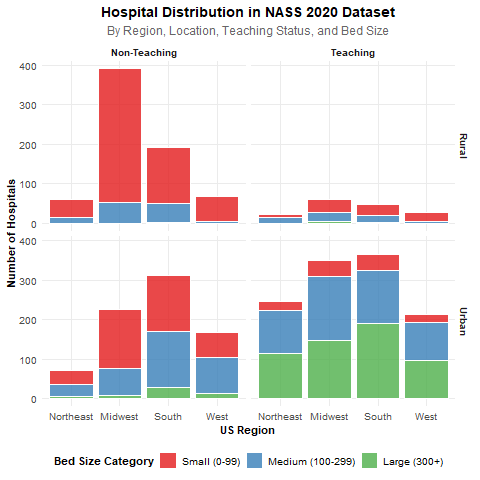

In [42]:
%%R

# Hospital distribution by region and characteristics
if(all(c("HOSP_REGION", "HOSP_BEDSIZE_CAT", "HOSP_LOCATION", "HOSP_TEACH") %in% names(NASS))) {
  
  # Get unique hospital characteristics
  hospital_chars <- unique(NASS[, .(HOSP_NASS, HOSP_LOCATION, HOSP_TEACH, 
                                   HOSP_REGION, HOSP_BEDSIZE_CAT)])
  
  # Define labels
  bed_labels <- c("1" = "Small (0-99)", "2" = "Medium (100-299)", "3" = "Large (300+)")
  region_labels <- c("1" = "Northeast", "2" = "Midwest", "3" = "South", "4" = "West")
  teach_labels <- c("0" = "Non-Teaching", "1" = "Teaching")
  location_labels <- c("0" = "Rural", "1" = "Urban")
  
  p1 <- ggplot(hospital_chars, aes(x = factor(HOSP_REGION), fill = factor(HOSP_BEDSIZE_CAT))) + 
    geom_bar(alpha = 0.8, color = "white", size = 0.3) + 
    theme_nass + 
    labs(
      x = "US Region", 
      y = "Number of Hospitals",
      title = "Hospital Distribution in NASS 2020 Dataset", 
      subtitle = "By Region, Location, Teaching Status, and Bed Size",
      fill = "Bed Size Category"
    ) + 
    scale_fill_manual(values = region_colors, labels = bed_labels) + 
    scale_x_discrete(labels = region_labels) +
    facet_grid(HOSP_LOCATION ~ HOSP_TEACH, 
               labeller = labeller(HOSP_TEACH = teach_labels, 
                                 HOSP_LOCATION = location_labels)) +
    theme(legend.position = "bottom")
  
  print(p1)
  
  cat("Hospital distribution plot generated for", nrow(hospital_chars), "hospitals\n")
}

#### Hospital Volume Analysis

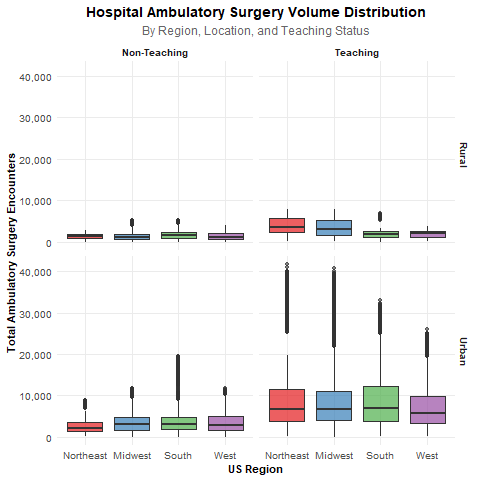

In [43]:
%%R

#  Hospital encounter volume distribution
if("TOTAL_AS_ENCOUNTERS" %in% names(NASS)) {
  
  hospital_volumes <- unique(NASS[, .(HOSP_NASS, HOSP_LOCATION, HOSP_TEACH, 
                                     HOSP_REGION, TOTAL_AS_ENCOUNTERS)])
  
  p2 <- ggplot(hospital_volumes, aes(x = factor(HOSP_REGION), y = TOTAL_AS_ENCOUNTERS)) + 
    geom_boxplot(aes(fill = factor(HOSP_REGION)), alpha = 0.7, outlier.alpha = 0.6) + 
    theme_nass + 
    labs(
      x = "US Region", 
      y = "Total Ambulatory Surgery Encounters",
      title = "Hospital Ambulatory Surgery Volume Distribution", 
      subtitle = "By Region, Location, and Teaching Status"
    ) + 
    scale_fill_manual(values = region_colors, labels = region_labels, guide = "none") + 
    scale_x_discrete(labels = region_labels) +
    scale_y_continuous(labels = comma_format()) +
    facet_grid(HOSP_LOCATION ~ HOSP_TEACH, 
               labeller = labeller(HOSP_TEACH = teach_labels, 
                                 HOSP_LOCATION = location_labels))
  
  print(p2)
}

### Top Procedures Analysis

#### Top Procedures Identification

In [44]:
%%R

# Calculate and display top 10 procedures
if("CPTCCS1" %in% names(NASS)) {
  
  # Calculate top procedures
  top_procedures <- NASS[, .N, by = CPTCCS1][order(-N)][1:10]
  TopCPT <- top_procedures$CPTCCS1
  
  cat("Top 10 procedures (CPTCCS1):\n")
  print(top_procedures)
  
  # Calculate coverage
  coverage <- sum(top_procedures$N) / nrow(NASS)
  cat("\nTop 10 procedures represent", round(coverage * 100, 1), "% of all procedures\n")
  
  # Create subset for detailed analysis
  NASS_top_procedures <- NASS[CPTCCS1 %in% TopCPT]
  cat("Created subset with", nrow(NASS_top_procedures), "records for top procedures\n")
}

Top 10 procedures (CPTCCS1):
    CPTCCS1     N
     <fctr> <int>
 1:      15 11335
 2:     160  8579
 3:      84  7056
 4:     152  5198
 5:      85  5066
 6:     162  4269
 7:      86  4260
 8:     124  4154
 9:     175  3813
10:       6  3715

Top 10 procedures represent 41.3 % of all procedures
Created subset with 57445 records for top procedures


#### Procedures by Income Quartile

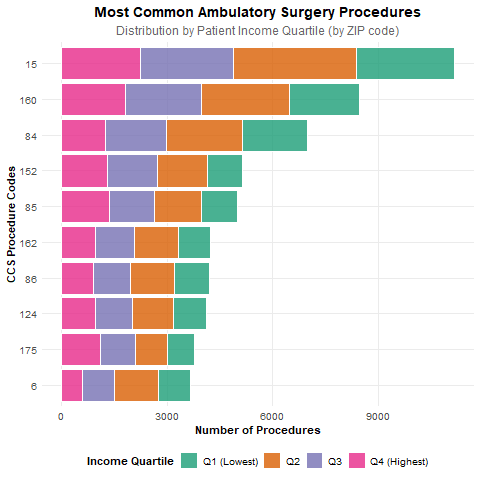

In [45]:
%%R

# Top procedures by income quartile
if(exists("NASS_top_procedures") && "ZIPINC_QRTL" %in% names(NASS)) {
  
  plot_data <- NASS_top_procedures[ZIPINC_QRTL %in% 1:4]
  
  if(nrow(plot_data) > 0) {
    # Order procedures by frequency
    proc_order <- plot_data[, .N, by = CPTCCS1][order(-N)]$CPTCCS1
    plot_data[, CPTCCS1 := factor(CPTCCS1, levels = rev(proc_order))]
    
    p3 <- ggplot(plot_data, aes(x = CPTCCS1, fill = factor(ZIPINC_QRTL))) + 
      geom_bar(alpha = 0.8, color = "white", size = 0.2) + 
      coord_flip() +
      theme_nass + 
      labs(
        x = "CCS Procedure Codes", 
        y = "Number of Procedures",
        title = "Most Common Ambulatory Surgery Procedures", 
        subtitle = "Distribution by Patient Income Quartile (by ZIP code)",
        fill = "Income Quartile"
      ) +
      scale_fill_manual(values = pay_colors[1:4], 
                       labels = c("Q1 (Lowest)", "Q2", "Q3", "Q4 (Highest)")) +
      theme(legend.position = "bottom")
    
    print(p3)
  }
}

#### Procedures by Race

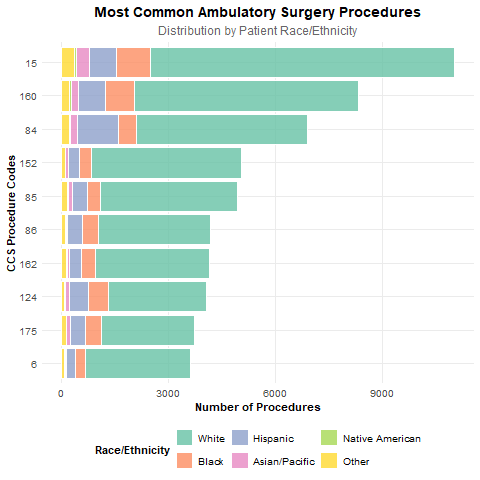

In [46]:
%%R

# Top procedures by race
if(exists("NASS_top_procedures") && "RACE" %in% names(NASS)) {
  
  plot_data <- NASS_top_procedures[RACE %in% 1:6]
  
  if(nrow(plot_data) > 0) {
    # Order procedures by frequency
    proc_order <- plot_data[, .N, by = CPTCCS1][order(-N)]$CPTCCS1
    plot_data[, CPTCCS1 := factor(CPTCCS1, levels = rev(proc_order))]
    
    race_labels <- c("1" = "White", "2" = "Black", "3" = "Hispanic", 
                    "4" = "Asian/Pacific", "5" = "Native American", "6" = "Other")
    
    p4 <- ggplot(plot_data, aes(x = CPTCCS1, fill = factor(RACE))) + 
      geom_bar(alpha = 0.8, color = "white", size = 0.2) + 
      coord_flip() +
      theme_nass + 
      labs(
        x = "CCS Procedure Codes", 
        y = "Number of Procedures",
        title = "Most Common Ambulatory Surgery Procedures", 
        subtitle = "Distribution by Patient Race/Ethnicity",
        fill = "Race/Ethnicity"
      ) + 
      scale_fill_manual(values = race_colors, labels = race_labels) +
      theme(legend.position = "bottom")
    
    print(p4)
  }
}

### Patient Characteristics Analysis

#### Age Distribution by Race and Region

In addition: Warning messages:
1: Groups with fewer than two data points have been dropped. 
2: In max(ids, na.rm = TRUE) :
  no non-missing arguments to max; returning -Inf


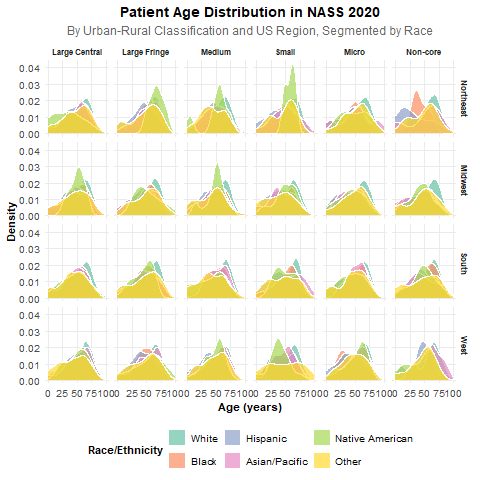

In [47]:
%%R

# Age distribution by race and region
if(all(c("AGE", "RACE", "HOSP_REGION", "PL_NCHS") %in% names(NASS))) {
  
  age_data <- NASS[RACE %in% 1:6 & PL_NCHS %in% 1:6 & AGE >= 0 & AGE <= 100]
  
  if(nrow(age_data) > 0) {
    
    race_labels <- c("1" = "White", "2" = "Black", "3" = "Hispanic", 
                    "4" = "Asian/Pacific", "5" = "Native American", "6" = "Other")
    region_labels <- c("1" = "Northeast", "2" = "Midwest", "3" = "South", "4" = "West")
    pl_nchs_labels <- c("1" = "Large Central", "2" = "Large Fringe", "3" = "Medium", 
                       "4" = "Small", "5" = "Micro", "6" = "Non-core")
    
    p5 <- ggplot(age_data, aes(x = AGE)) + 
      geom_density(aes(fill = factor(RACE)), alpha = 0.7, color = "white", size = 0.2) + 
      theme_nass + 
      labs(
        x = "Age (years)", 
        y = "Density",
        title = "Patient Age Distribution in NASS 2020", 
        subtitle = "By Urban-Rural Classification and US Region, Segmented by Race",
        fill = "Race/Ethnicity"
      ) + 
      scale_fill_manual(values = race_colors, labels = race_labels) + 
      xlim(0, 100) +
      facet_grid(HOSP_REGION ~ PL_NCHS, 
                 labeller = labeller(HOSP_REGION = region_labels, PL_NCHS = pl_nchs_labels)) + 
      theme(legend.position = "bottom", 
            strip.text = element_text(size = 8))
    
    print(p5)
  }
}

#### Age Distribution by Payer

In addition: Warning messages:
1: Groups with fewer than two data points have been dropped. 
2: Groups with fewer than two data points have been dropped. 
3: In max(ids, na.rm = TRUE) :
  no non-missing arguments to max; returning -Inf
4: In max(ids, na.rm = TRUE) :
  no non-missing arguments to max; returning -Inf


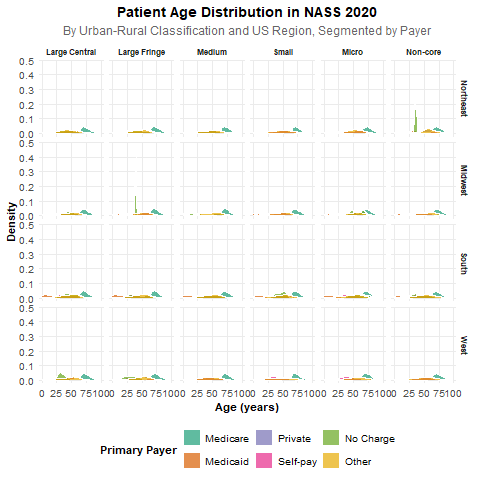

In [48]:
%%R

# Age distribution by payer and region
if(all(c("AGE", "PAY1", "HOSP_REGION", "PL_NCHS") %in% names(NASS))) {
  
  age_payer_data <- NASS[PAY1 %in% 1:6 & PL_NCHS %in% 1:6 & AGE >= 0 & AGE <= 100]
  
  if(nrow(age_payer_data) > 0) {
    
    pay_labels <- c("1" = "Medicare", "2" = "Medicaid", "3" = "Private", 
                   "4" = "Self-pay", "5" = "No Charge", "6" = "Other")
    
    p6 <- ggplot(age_payer_data, aes(x = AGE)) + 
      geom_density(aes(fill = factor(PAY1)), alpha = 0.7, color = "white", size = 0.2) + 
      theme_nass + 
      labs(
        x = "Age (years)", 
        y = "Density",
        title = "Patient Age Distribution in NASS 2020", 
        subtitle = "By Urban-Rural Classification and US Region, Segmented by Payer",
        fill = "Primary Payer"
      ) + 
      scale_fill_manual(values = pay_colors, labels = pay_labels) + 
      xlim(0, 100) +
      facet_grid(HOSP_REGION ~ PL_NCHS, 
                 labeller = labeller(HOSP_REGION = region_labels, PL_NCHS = pl_nchs_labels)) + 
      theme(legend.position = "bottom",
            strip.text = element_text(size = 8))
    
    print(p6)
  }
}

#### Payer Distribution by Demographics

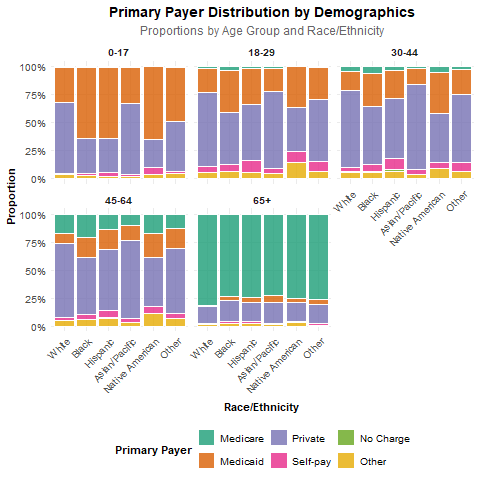

In [49]:
%%R

# Payer distribution by race and age group
if(all(c("RACE", "PAY1", "AGE_GROUP") %in% names(NASS))) {
  
  payer_demo_data <- NASS[RACE %in% 1:6 & PAY1 %in% 1:6 & !is.na(AGE_GROUP)]
  
  if(nrow(payer_demo_data) > 0) {
    
    p7 <- ggplot(payer_demo_data, aes(x = factor(RACE), fill = factor(PAY1))) + 
      geom_bar(position = "fill", alpha = 0.8, color = "white", size = 0.2) + 
      theme_nass + 
      labs(
        x = "Race/Ethnicity", 
        y = "Proportion",
        title = "Primary Payer Distribution by Demographics", 
        subtitle = "Proportions by Age Group and Race/Ethnicity",
        fill = "Primary Payer"
      ) + 
      scale_fill_manual(values = pay_colors, labels = pay_labels) + 
      scale_x_discrete(labels = race_labels) +
      scale_y_continuous(labels = percent_format()) +
      facet_wrap(~ AGE_GROUP, ncol = 3) +
      theme(axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "bottom")
    
    print(p7)
  }
}

### Comprehensive Dataset Summary

Final summary statistics providing an overview of all key variables in the analysis.

In [61]:
%%R

# ===============================================
# COMPREHENSIVE NASS 2020 DATASET SUMMARY
# ===============================================

cat("================================================================\n")
cat("                    NASS 2020 DATASET SUMMARY                  \n")
cat("================================================================\n\n")

# Dataset Overview
cat("DATASET OVERVIEW\n")
cat("================\n")
cat("Total observations:", format(nrow(NASS), big.mark = ","), "\n")
cat("Total variables:", ncol(NASS), "\n")
cat("Memory usage:", round(object.size(NASS)/1024^2, 1), "MB\n")
cat("Missing data patterns:", sum(is.na(NASS)), "total missing values\n\n")

# Key variables for comprehensive summary
summary_vars <- c("AGE", "FEMALE", "RACE", "WHITE", "ZIPINC_QRTL", "PAY1", 
                 "HOSP_LOCATION", "HOSP_TEACH", "HOSP_REGION", "HOSP_BEDSIZE_CAT",
                 "PL_NCHS", "CPTCCS1", "TOTCHG", "DISCWT")

available_vars <- summary_vars[summary_vars %in% names(NASS)]
missing_vars <- summary_vars[!summary_vars %in% names(NASS)]

if(length(missing_vars) > 0) {
  cat("WARNING: Variables not available:", paste(missing_vars, collapse = ", "), "\n\n")
}

# Variable-by-variable analysis
for(var in available_vars) {
  cat("----------------------------------------------------------------\n")
  cat("Variable:", toupper(var), "\n")
  cat("----------------------------------------------------------------\n")
  
  if(is.numeric(NASS[[var]])) {
    # Enhanced numeric variable summary
    valid_values <- NASS[[var]][!is.na(NASS[[var]])]
    missing_count <- sum(is.na(NASS[[var]]))
    
    cat("Type: Continuous/Numeric\n")
    cat("Valid observations:", format(length(valid_values), big.mark = ","), 
        "(", round(100 * length(valid_values) / nrow(NASS), 1), "%)\n")
    cat("Missing values:", format(missing_count, big.mark = ","), 
        "(", round(100 * missing_count / nrow(NASS), 1), "%)\n")
    
    if(length(valid_values) > 0) {
      # Central tendency
      cat("\nCENTRAL TENDENCY:\n")
      cat("   Mean:", format(round(mean(valid_values), 2), big.mark = ","), "\n")
      cat("   Median:", format(round(median(valid_values), 2), big.mark = ","), "\n")
      cat("   Mode region:", format(round(median(valid_values), 2), big.mark = ","), 
          " +/-", format(round(mad(valid_values), 2), big.mark = ","), "\n")
      
      # Variability
      cat("\nVARIABILITY:\n")
      cat("   Standard Dev:", format(round(sd(valid_values), 2), big.mark = ","), "\n")
      cat("   IQR:", format(round(quantile(valid_values, 0.25), 2), big.mark = ","), "to", 
          format(round(quantile(valid_values, 0.75), 2), big.mark = ","), "\n")
      cat("   Range:", format(round(min(valid_values), 2), big.mark = ","), "to", 
          format(round(max(valid_values), 2), big.mark = ","), "\n")
      
      # Distribution shape
      cat("\nDISTRIBUTION:\n")
      q1 <- quantile(valid_values, 0.25)
      q3 <- quantile(valid_values, 0.75)
      skewness_approx <- (mean(valid_values) - median(valid_values)) / sd(valid_values)
      
      cat("   Skewness (approx):", round(skewness_approx, 3), 
          ifelse(abs(skewness_approx) < 0.5, "(approximately symmetric)", 
                ifelse(skewness_approx > 0, "(right-skewed)", "(left-skewed)")), "\n")
      
      # Outliers (using IQR method)
      iqr <- q3 - q1
      lower_fence <- q1 - 1.5 * iqr
      upper_fence <- q3 + 1.5 * iqr
      outliers <- sum(valid_values < lower_fence | valid_values > upper_fence)
      cat("   Potential outliers:", outliers, 
          "(", round(100 * outliers / length(valid_values), 1), "%)\n")
      
      # Percentile breakdown for key variables
      if(var %in% c("AGE", "TOTCHG", "DISCWT")) {
        cat("\nPERCENTILE BREAKDOWN:\n")
        percentiles <- c(0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99)
        for(p in percentiles) {
          cat("   P", round(p*100), ":", format(round(quantile(valid_values, p), 1), big.mark = ","), "\n")
        }
      }
    }
    
  } else {
    # Enhanced categorical variable summary
    freq_table <- table(NASS[[var]], useNA = "ifany")
    total_n <- sum(freq_table)
    missing_count <- sum(is.na(NASS[[var]]))
    
    cat("Type: Categorical/Factor\n")
    cat("Total categories:", length(freq_table), "\n")
    cat("Valid observations:", format(total_n - missing_count, big.mark = ","), 
        "(", round(100 * (total_n - missing_count) / nrow(NASS), 1), "%)\n")
    
    if(missing_count > 0) {
      cat("Missing values:", format(missing_count, big.mark = ","), 
          "(", round(100 * missing_count / nrow(NASS), 1), "%)\n")
    }
    
    # Sort by frequency
    sorted_freq <- sort(freq_table, decreasing = TRUE)
    
    # Show distribution
    cat("\nFREQUENCY DISTRIBUTION:\n")
    max_show <- min(15, length(sorted_freq))  # Show more categories
    
    for(i in 1:max_show) {
      category_name <- names(sorted_freq)[i]
      count <- sorted_freq[i]
      percentage <- round(100 * count / total_n, 1)
      
      # Create a simple bar visualization
      bar_length <- min(20, round(20 * count / max(sorted_freq)))
      bar <- paste(rep("*", bar_length), collapse = "")
      
      cat("   ", sprintf("%-20s", category_name), ":", 
          sprintf("%8s", format(count, big.mark = ",")), 
          sprintf("(%5.1f%%)", percentage), " ", bar, "\n")
    }
    
    if(length(sorted_freq) > max_show) {
      remaining_count <- sum(sorted_freq[(max_show+1):length(sorted_freq)])
      remaining_pct <- round(100 * remaining_count / total_n, 1)
      cat("   ... ", length(sorted_freq) - max_show, " more categories:", 
          format(remaining_count, big.mark = ","), "(", remaining_pct, "%)\n")
    }
    
    # Diversity metrics
    cat("\nDIVERSITY METRICS:\n")
    # Simpson's diversity index (1 - sum of squared proportions)
    proportions <- as.numeric(freq_table) / sum(freq_table)
    simpson_diversity <- 1 - sum(proportions^2)
    cat("   Simpson's Diversity:", round(simpson_diversity, 3), 
        "(0=no diversity, 1=max diversity)\n")
    
    # Effective number of categories (inverse Simpson)
    effective_categories <- 1 / sum(proportions^2)
    cat("   Effective categories:", round(effective_categories, 1), 
        "out of", length(freq_table), "total\n")
    
    # Concentration ratio (top 3 categories)
    top3_concentration <- sum(sorted_freq[1:min(3, length(sorted_freq))]) / total_n
    cat("   Top-3 concentration:", round(100 * top3_concentration, 1), "%\n")
    
    # Special insights for key variables
    if(var == "RACE") {
      cat("\nRACE/ETHNICITY INSIGHTS:\n")
      cat("   Racial diversity reflects ambulatory surgery access patterns\n")
      if("1" %in% names(freq_table)) {
        white_vs_nonwhite <- round(freq_table["1"] / sum(freq_table[names(freq_table) != "1"]), 2)
        cat("   White vs Non-White ratio:", white_vs_nonwhite, ":1\n")
      }
    }
    
    if(var == "PAY1") {
      cat("\nPAYER MIX INSIGHTS:\n")
      public_payers <- sum(freq_table[c("1", "2")], na.rm = TRUE)  # Medicare + Medicaid
      cat("   Public insurance coverage:", 
          round(100 * public_payers / total_n, 1), "%\n")
    }
    
    if(var == "ZIPINC_QRTL") {
      cat("\nINCOME DISTRIBUTION INSIGHTS:\n")
      low_income <- sum(freq_table[c("1", "2")], na.rm = TRUE)  # Q1 + Q2
      cat("   Lower-income representation:", 
          round(100 * low_income / total_n, 1), "%\n")
    }
  }
  cat("\n")
}

# Cross-tabulation insights
cat("----------------------------------------------------------------\n")
cat("KEY RELATIONSHIPS & CROSS-TABULATIONS\n")
cat("----------------------------------------------------------------\n\n")

# Race vs Payer cross-tab
if(all(c("RACE", "PAY1") %in% available_vars)) {
  cat("RACE x PAYER DISTRIBUTION:\n")
  cross_tab <- table(NASS$RACE, NASS$PAY1)
  prop_tab <- round(100 * prop.table(cross_tab, 1), 1)
  
  race_labels <- c("1"="White", "2"="Black", "3"="Hispanic", "4"="Asian/Pacific", "5"="Native Am", "6"="Other")
  pay_labels <- c("1"="Medicare", "2"="Medicaid", "3"="Private", "4"="Self-pay", "5"="No Charge", "6"="Other")
  
  for(race in rownames(prop_tab)) {
    if(race %in% names(race_labels)) {
      cat("   ", race_labels[race], "patients:\n")
      race_row <- prop_tab[race, ]
      sorted_payers <- sort(race_row, decreasing = TRUE)
      for(i in 1:min(3, length(sorted_payers))) {
        payer <- names(sorted_payers)[i]
        if(payer %in% names(pay_labels)) {
          cat("     ", pay_labels[payer], ":", sorted_payers[i], "%\n")
        }
      }
    }
  }
  cat("\n")
}

# Age vs Income relationship
if(all(c("AGE", "ZIPINC_QRTL") %in% available_vars)) {
  cat("AGE x INCOME PATTERNS:\n")
  age_income <- NASS[!is.na(AGE) & !is.na(ZIPINC_QRTL), .(mean_age = round(mean(AGE), 1)), by = ZIPINC_QRTL]
  setorder(age_income, ZIPINC_QRTL)
  
  income_labels <- c("1"="Q1 (Lowest)", "2"="Q2", "3"="Q3", "4"="Q4 (Highest)")
  for(i in 1:nrow(age_income)) {
    quartile <- as.character(age_income$ZIPINC_QRTL[i])
    if(quartile %in% names(income_labels)) {
      cat("   ", income_labels[quartile], "- Average age:", age_income$mean_age[i], "years\n")
    }
  }
  cat("\n")
}

# Hospital characteristics summary
if(all(c("HOSP_REGION", "HOSP_TEACH", "HOSP_LOCATION") %in% available_vars)) {
  cat("HOSPITAL CHARACTERISTICS:\n")
  
  # Unique hospital count
  if("HOSP_NASS" %in% names(NASS)) {
    unique_hospitals <- length(unique(NASS$HOSP_NASS))
    cat("   Total hospitals in sample:", unique_hospitals, "\n")
  }
  
  # Teaching hospital distribution
  teaching_dist <- table(NASS$HOSP_TEACH)
  if("1" %in% names(teaching_dist)) {
    cat("   Teaching hospitals:", round(100 * teaching_dist["1"] / sum(teaching_dist), 1), "%\n")
  }
  
  # Urban/Rural distribution
  location_dist <- table(NASS$HOSP_LOCATION)
  if("1" %in% names(location_dist)) {
    cat("   Urban hospitals:", round(100 * location_dist["1"] / sum(location_dist), 1), "%\n")
  }
  
  # Regional distribution
  region_dist <- table(NASS$HOSP_REGION)
  region_labels <- c("1"="Northeast", "2"="Midwest", "3"="South", "4"="West")
  cat("   Regional distribution:\n")
  for(region in names(region_dist)) {
    if(region %in% names(region_labels)) {
      pct <- round(100 * region_dist[region] / sum(region_dist), 1)
      cat("     ", region_labels[region], ":", pct, "%\n")
    }
  }
  cat("\n")
}

# Data quality assessment
cat("----------------------------------------------------------------\n")
cat("DATA QUALITY ASSESSMENT\n")
cat("----------------------------------------------------------------\n\n")

# Missing data patterns
total_cells <- nrow(NASS) * ncol(NASS)
missing_cells <- sum(is.na(NASS))
complete_cases <- sum(complete.cases(NASS))

cat("COMPLETENESS METRICS:\n")
cat("   Overall completeness:", round(100 * (1 - missing_cells/total_cells), 2), "%\n")
cat("   Complete cases (no missing):", format(complete_cases, big.mark = ","), 
    "(", round(100 * complete_cases / nrow(NASS), 1), "%)\n")
cat("   Variables with missing data:", sum(sapply(NASS, function(x) any(is.na(x)))), 
    "out of", ncol(NASS), "\n\n")

# Variables with highest missing rates
missing_rates <- sapply(NASS, function(x) round(100 * sum(is.na(x)) / length(x), 1))
high_missing <- missing_rates[missing_rates > 0]
if(length(high_missing) > 0) {
  cat("VARIABLES WITH MISSING DATA:\n")
  sorted_missing <- sort(high_missing, decreasing = TRUE)
  for(i in 1:min(10, length(sorted_missing))) {
    cat("   ", names(sorted_missing)[i], ":", sorted_missing[i], "% missing\n")
  }
  cat("\n")
}

# Survey weights summary
if("DISCWT" %in% available_vars) {
  cat("SURVEY WEIGHTS SUMMARY:\n")
  weights <- NASS$DISCWT[!is.na(NASS$DISCWT)]
  cat("   Weight range:", round(min(weights), 2), "to", round(max(weights), 2), "\n")
  cat("   Effective sample size:", round(sum(weights)^2 / sum(weights^2)), "\n")
  cat("   Design effect (approx):", round(nrow(NASS) / (sum(weights)^2 / sum(weights^2)), 2), "\n\n")
}

cat("================================================================\n")
cat("                     SUMMARY COMPLETE                          \n")
cat("     Dataset ready for advanced statistical analysis           \n")
cat("================================================================\n")

                    NASS 2020 DATASET SUMMARY                  

DATASET OVERVIEW
Total observations: 139,233 
Total variables: 79 
Memory usage: 60.5 MB
Missing data patterns: 0 total missing values

----------------------------------------------------------------
Variable: AGE 
----------------------------------------------------------------
Type: Continuous/Numeric
Valid observations: 139,233 ( 100 %)
Missing values: 0 ( 0 %)

CENTRAL TENDENCY:
   Mean: 52.06 
   Median: 56 
   Mode region: 56  +/- 20.76 

VARIABILITY:
   Standard Dev: 21.53 
   IQR: 38 to 68 
   Range: 0 to 104 

DISTRIBUTION:
   Skewness (approx): -0.183 (approximately symmetric) 
   Potential outliers: 0 ( 0 %)

PERCENTILE BREAKDOWN:
   P 1 : 1 
   P 5 : 9 
   P 10 : 20 
   P 25 : 38 
   P 50 : 56 
   P 75 : 68 
   P 90 : 77 
   P 95 : 82 
   P 99 : 89 

----------------------------------------------------------------
Variable: FEMALE 
----------------------------------------------------------------
Type: Categor

In [57]:
%%R

# Install gtsummary and dependencies if needed
if(!require("gtsummary", quietly = TRUE)) {
  install.packages(c("gtsummary", "gt", "dplyr"), dependencies = TRUE)
  library(gtsummary)
}

# Also load required dependencies
library(dplyr)

# Generate comprehensive summary table
# Select key variables for summary
summary_vars <- c("AGE", "FEMALE", "RACE", "ZIPINC_QRTL", "PAY1", 
                 "HOSP_LOCATION", "HOSP_TEACH", "HOSP_REGION")

available_vars <- summary_vars[summary_vars %in% names(NASS)]
cat("Available variables for summary:", paste(available_vars, collapse = ", "), "\n")

if(length(available_vars) > 0) {
  
  # Convert to data.frame and apply labels
  summary_data <- as.data.frame(NASS[, ..available_vars])
  
  # Apply factor labels
  if("RACE" %in% available_vars) {
    summary_data$RACE <- factor(summary_data$RACE, levels = 1:6, 
                               labels = c("White", "Black", "Hispanic", 
                                        "Asian/Pacific", "Native American", "Other"))
  }
  if("PAY1" %in% available_vars) {
    summary_data$PAY1 <- factor(summary_data$PAY1, levels = 1:6, 
                               labels = c("Medicare", "Medicaid", "Private", 
                                        "Self-pay", "No Charge", "Other"))
  }
  if("FEMALE" %in% available_vars) {
    summary_data$FEMALE <- factor(summary_data$FEMALE, levels = 0:1, 
                                 labels = c("Male", "Female"))
  }
  if("HOSP_LOCATION" %in% available_vars) {
    summary_data$HOSP_LOCATION <- factor(summary_data$HOSP_LOCATION, levels = 0:1, 
                                        labels = c("Rural", "Urban"))
  }
  if("HOSP_TEACH" %in% available_vars) {
    summary_data$HOSP_TEACH <- factor(summary_data$HOSP_TEACH, levels = 0:1, 
                                     labels = c("Non-Teaching", "Teaching"))
  }
  if("HOSP_REGION" %in% available_vars) {
    summary_data$HOSP_REGION <- factor(summary_data$HOSP_REGION, levels = 1:4, 
                                      labels = c("Northeast", "Midwest", "South", "West"))
  }
  if("ZIPINC_QRTL" %in% available_vars) {
    summary_data$ZIPINC_QRTL <- factor(summary_data$ZIPINC_QRTL, levels = 1:4, 
                                      labels = c("Q1 (Lowest)", "Q2", "Q3", "Q4 (Highest)"))
  }
  
  # Try gtsummary first
  tryCatch({
    summary_table <- summary_data %>%
      tbl_summary(
        statistic = list(
          all_continuous() ~ "{mean} ({sd})",
          all_categorical() ~ "{n} ({p}%)"
        ),
        digits = all_continuous() ~ 1
      ) %>%
      modify_header(label ~ "**Variable**") %>%
      modify_caption("**NASS 2020 Ambulatory Surgery Dataset Summary**")
    
    # Force print the table
    print(summary_table)
    cat("gtsummary table generated successfully\n")
    
  }, error = function(e) {
    cat("gtsummary failed, using base R summary:\n")
    cat("Error:", e$message, "\n\n")
    
    # Fallback to base R summary
    cat("=== DATASET SUMMARY (Base R) ===\n")
    cat("Total observations:", nrow(summary_data), "\n\n")
    
    for(var in names(summary_data)) {
      cat("Variable:", var, "\n")
      if(is.numeric(summary_data[[var]])) {
        cat("  Mean (SD):", round(mean(summary_data[[var]], na.rm = TRUE), 1), 
            "(", round(sd(summary_data[[var]], na.rm = TRUE), 1), ")\n")
        cat("  Range:", round(min(summary_data[[var]], na.rm = TRUE), 1), "to", 
            round(max(summary_data[[var]], na.rm = TRUE), 1), "\n")
      } else {
        cat("  Frequencies:\n")
        freq_table <- table(summary_data[[var]], useNA = "ifany")
        for(i in 1:length(freq_table)) {
          cat("    ", names(freq_table)[i], ":", freq_table[i], 
              "(", round(100 * freq_table[i] / sum(freq_table), 1), "%)\n")
        }
      }
      cat("\n")
    }
  })
  
} else {
  cat("No variables available for summary\n")
}

cat("\n=== COMPREHENSIVE DATASET OVERVIEW COMPLETE ===\n")

Available variables for summary: AGE, FEMALE, RACE, ZIPINC_QRTL, PAY1, HOSP_LOCATION, HOSP_TEACH, HOSP_REGION 
gtsummary table generated successfully

=== COMPREHENSIVE DATASET OVERVIEW COMPLETE ===


=== NASS 2020 DATASET SUMMARY ===
Total observations: 139233 
Total variables: 79 

-----------------------------------------------
Variable: AGE 
  Type: Continuous
  Mean (SD): 52.1 ( 21.5 )
  Median [IQR]: 56 [ 38 - 68 ]
  Range: 0 to 104 
  Missing: 0 observations

-----------------------------------------------
Variable: FEMALE 
  Type: Categorical
  Levels: 2 
     TRUE : 77409 ( 55.6 %)
     FALSE : 61824 ( 44.4 %)

-----------------------------------------------
Variable: RACE 
  Type: Categorical
  Levels: 8 
     1 : 100418 ( 72.1 %)
     3 : 13724 ( 9.9 %)
     2 : 13013 ( 9.3 %)
     6 : 4165 ( 3 %)
     -9 : 3868 ( 2.8 %)
     4 : 3399 ( 2.4 %)
     5 : 645 ( 0.5 %)
     -8 : 1 ( 0 %)

-----------------------------------------------
Variable: ZIPINC_QRTL 
  Type: Categorical
  Levels: 6 
     2 : 39311 ( 28.2 %)
     3 : 34833 ( 25 %)
     1 : 31913 ( 22.9 %)
     4 : 31625 ( 22.7 %)
     -9 : 1550 ( 1.1 %)
     -8 : 1 ( 0 %)

----------------------------------------------

---

## 2. Census Data Comparisons


### Census API Setup

Set up Census API integration and pull 2020 DHC population data for comparison with NASS sample proportions.

[ Please Register at the Census website for an API Key ](https://api.census.gov/data/key_signup.html). Enter your Census API key for data retrieval:

In [51]:
import getpass, os, json, textwrap
os.environ["CENSUS_API_KEY"] = getpass.getpass("Enter your Census API key (will not echo):")

### Census Data Retrieval and Processing

Pull 2020 DHC population data by age, gender, and race for states included in NASS sample.

In [52]:
%%R -i VERBOSE_PRINTS

# Install and load required packages for Census analysis
required_packages <- c("tidycensus", "dplyr", "tidyr", "survey")

for(pkg in required_packages) {
  if(!require(pkg, character.only = TRUE, quietly = TRUE)) {
    install.packages(pkg, quiet = TRUE)
    library(pkg, character.only = TRUE, quietly = TRUE)
  }
}

# Set Census API key
census_api_key(Sys.getenv("CENSUS_API_KEY"), overwrite = FALSE, install = FALSE)

# Define states included in NASS 2020 dataset
states_in_nass <- c("Alaska", "California", "Colorado", "Connecticut", "District of Columbia", 
                    "Florida", "Georgia", "Hawaii", "Iowa", "Illinois", "Indiana", "Kansas", 
                    "Kentucky", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", 
                    "North Carolina", "North Dakota", "Nebraska", "New Jersey", "Nevada", 
                    "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "South Carolina", 
                    "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Wisconsin")

cat("Defined", length(states_in_nass), "states included in NASS sample\n")

# Function to construct population variables for Census queries
get_population_variables <- function(base_variable) {
    variables <- paste0(base_variable, "_", sprintf("%03dN", 1:49))
    
    labels <- c(
        "Total",
        "Male: Total", "Male: Under 5 years", "Male: 5 to 9 years", "Male: 10 to 14 years",
        "Male: 15 to 17 years", "Male: 18 and 19 years", "Male: 20 years", "Male: 21 years",
        "Male: 22 to 24 years", "Male: 25 to 29 years", "Male: 30 to 34 years", "Male: 35 to 39 years",
        "Male: 40 to 44 years", "Male: 45 to 49 years", "Male: 50 to 54 years", "Male: 55 to 59 years",
        "Male: 60 and 61 years", "Male: 62 to 64 years", "Male: 65 and 66 years", "Male: 67 to 69 years",
        "Male: 70 to 74 years", "Male: 75 to 79 years", "Male: 80 to 84 years", "Male: 85 years and over",
        "Female: Total", "Female: Under 5 years", "Female: 5 to 9 years", "Female: 10 to 14 years",
        "Female: 15 to 17 years", "Female: 18 and 19 years", "Female: 20 years", "Female: 21 years",
        "Female: 22 to 24 years", "Female: 25 to 29 years", "Female: 30 to 34 years", "Female: 35 to 39 years",
        "Female: 40 to 44 years", "Female: 45 to 49 years", "Female: 50 to 54 years", "Female: 55 to 59 years",
        "Female: 60 and 61 years", "Female: 62 to 64 years", "Female: 65 and 66 years", "Female: 67 to 69 years",
        "Female: 70 to 74 years", "Female: 75 to 79 years", "Female: 80 to 84 years", "Female: 85 years and over"
    )
    
    names(labels) <- variables
    return(list(variables = variables, labels = labels))
}

# Function to get population data from Census
get_population_data <- function(variables, labels) {
    population_data <- get_decennial(
        geography = "state",
        variables = variables,
        year = 2020,
        sumfile = "dhc"
    )
    
    # Replace variable codes with descriptive labels
    population_data <- population_data %>% 
        mutate(variable = recode(variable, !!!setNames(labels, variables)))
    
    # Reshape data for analysis
    population_data <- population_data %>% 
        pivot_wider(names_from = variable, values_from = value)
    
    return(population_data)
}

# Get total population data (all races)
cat("Retrieving total population data from 2020 Census...\n")
population_info_total <- get_population_variables("P12")
total_population_by_age_gender <- get_population_data(population_info_total$variables, population_info_total$labels)

# Get white alone population data
cat("Retrieving white alone population data from 2020 Census...\n")
population_info_white <- get_population_variables("P12I")
total_population_by_age_gender_white <- get_population_data(population_info_white$variables, population_info_white$labels)

cat("Census data retrieval complete\n")

if(VERBOSE_PRINTS) {
  cat("\nTotal population data structure:\n")
  str(total_population_by_age_gender)
  cat("\nWhite population data structure:\n")
  str(total_population_by_age_gender_white)
}

Defined 35 states included in NASS sample
Retrieving total population data from 2020 Census...
Retrieving white alone population data from 2020 Census...
Census data retrieval complete

Total population data structure:
tibble [52 x 51] (S3: tbl_df/tbl/data.frame)
 $ GEOID                    : chr [1:52] "09" "10" "11" "12" ...
 $ NAME                     : chr [1:52] "Connecticut" "Delaware" "District of Columbia" "Florida" ...
 $ Total                    : num [1:52] 3605944 989948 689545 21538187 10711908 ...
 $ Male: Total              : num [1:52] 1749853 476719 322777 10464234 5188570 ...
 $ Male: Under 5 years      : num [1:52] 89943 26159 18908 525258 312206 ...
 $ Male: 5 to 9 years       : num [1:52] 101027 28828 17025 588724 345849 ...
 $ Male: 10 to 14 years     : num [1:52] 112896 31116 14619 645046 382923 ...
 $ Male: 15 to 17 years     : num [1:52] 72413 18794 7598 386492 229248 ...
 $ Male: 18 and 19 years    : num [1:52] 49943 12907 8269 268089 155388 ...
 $ Male: 20 ye

To install your API key for use in future sessions, run this function with `install = TRUE`.
Getting data from the 2020 decennial Census
Using the Demographic and Housing Characteristics File
Using the Demographic and Housing Characteristics File
Getting data from the 2020 decennial Census
Using the Demographic and Housing Characteristics File
Using the Demographic and Housing Characteristics File


### Statistical Comparison: NASS vs Census Proportions

Compare unadjusted and weighted proportions of white individuals in NASS sample against Census benchmarks.

In [53]:
%%R

# ========================================
# Stage 1a: Unadjusted Proportion Analysis
# ========================================

cat("=== STAGE 1A: UNADJUSTED PROPORTION ANALYSIS ===\n")

# Calculate unadjusted proportion of white individuals in NASS
unadjusted_proportion_white <- mean(NASS$WHITE, na.rm = TRUE)
cat("Unadjusted proportion of WHITE in NASS:", round(unadjusted_proportion_white, 4), "\n")

# Calculate reference proportion from entire US Census
us_census_white_proportion <- sum(total_population_by_age_gender_white$Total, na.rm = TRUE) / 
                             sum(total_population_by_age_gender$Total, na.rm = TRUE)
cat("US Census White alone proportion:", round(us_census_white_proportion, 4), "\n")

# Statistical test for unadjusted proportion
unadjusted_test <- prop.test(sum(NASS$WHITE, na.rm = TRUE), 
                            sum(!is.na(NASS$WHITE)), 
                            p = us_census_white_proportion)
cat("\nUnadjusted proportion test results:\n")
print(unadjusted_test)

# ========================================
# Stage 1b: Weighted Proportion Analysis
# ========================================

cat("\n=== STAGE 1B: WEIGHTED PROPORTION ANALYSIS ===\n")

# Filter Census data for NASS-included states only
filtered_total_population <- total_population_by_age_gender %>% 
    filter(NAME %in% states_in_nass)

filtered_white_population <- total_population_by_age_gender_white %>% 
    filter(NAME %in% states_in_nass)

# Calculate true proportion for NASS states
total_population_nass_states <- sum(filtered_total_population$Total, na.rm = TRUE)
total_white_population_nass_states <- sum(filtered_white_population$Total, na.rm = TRUE)
true_proportion_white_nass_states <- total_white_population_nass_states / total_population_nass_states

cat("True proportion of WHITE in NASS states:", round(true_proportion_white_nass_states, 4), "\n")

# Calculate weighted proportion using survey design
survey_design <- svydesign(ids = ~1, weights = ~DISCWT, data = NASS)
weighted_proportion_white <- svymean(~WHITE, design = survey_design)
cat("Weighted proportion of WHITE in NASS:", round(coef(weighted_proportion_white), 4), "\n")

# Statistical test for weighted proportion
weighted_test <- svyttest(WHITE ~ 1, design = survey_design, mu = true_proportion_white_nass_states)
cat("\nWeighted proportion test results:\n")
print(weighted_test)

cat("\n=== PROPORTION ANALYSIS COMPLETE ===\n")

=== STAGE 1A: UNADJUSTED PROPORTION ANALYSIS ===
Unadjusted proportion of WHITE in NASS: 0.7212 
US Census White alone proportion: 0.5728 

Unadjusted proportion test results:

	1-sample proportions test with continuity correction

data:  sum(NASS$WHITE, na.rm = TRUE) out of sum(!is.na(NASS$WHITE)), null probability us_census_white_proportion
X-squared = 12541, df = 1, p-value < 2.2e-16
alternative hypothesis: true p is not equal to 0.5727579
95 percent confidence interval:
 0.7188578 0.7235754
Unadjusted proportion test results:

	1-sample proportions test with continuity correction

data:  sum(NASS$WHITE, na.rm = TRUE) out of sum(!is.na(NASS$WHITE)), null probability us_census_white_proportion
X-squared = 12541, df = 1, p-value < 2.2e-16
alternative hypothesis: true p is not equal to 0.5727579
95 percent confidence interval:
 0.7188578 0.7235754
sample estimates:
        p 
0.7212227 


=== STAGE 1B: WEIGHTED PROPORTION ANALYSIS ===
True proportion of WHITE in NASS states: 0.5684 

s

### Age-Gender Stratified Analysis

Detailed comparison of white proportions by age group and gender between NASS sample and Census data.

In [54]:
%%R

# ========================================
# Stage 2: Age-Gender Stratified Analysis
# ========================================

cat("=== STAGE 2: AGE-GENDER STRATIFIED ANALYSIS ===\n")

# Define age groups matching Census categories
age_breaks <- c(-Inf, 4, 9, 14, 17, 19, 20, 21, 24, 29, 34, 39, 44, 49, 54, 59, 61, 64, 66, 69, 74, 79, 84, Inf)
age_labels <- c("Under 5 years", "5 to 9 years", "10 to 14 years", "15 to 17 years", "18 and 19 years",
                "20 years", "21 years", "22 to 24 years", "25 to 29 years", "30 to 34 years",
                "35 to 39 years", "40 to 44 years", "45 to 49 years", "50 to 54 years", "55 to 59 years",
                "60 and 61 years", "62 to 64 years", "65 and 66 years", "67 to 69 years", "70 to 74 years",
                "75 to 79 years", "80 to 84 years", "85 years and over")

# Create age group variable in NASS dataset
NASS[, AGE_GROUP := cut(AGE, breaks = age_breaks, labels = age_labels, right = TRUE)]
NASS[, GENDER := ifelse(FEMALE == 0, "Male", "Female")]

cat("Created age groups and gender variables\n")

# Calculate NASS proportions by age group and gender
nass_proportions <- NASS[!is.na(AGE_GROUP) & !is.na(WHITE), 
                        .(total = .N,
                          white = sum(WHITE, na.rm = TRUE),
                          proportion_white = mean(WHITE, na.rm = TRUE)), 
                        by = .(AGE_GROUP, GENDER)]

# Add confidence intervals
nass_proportions[, ':='(
  ci_lower = proportion_white - 1.96 * sqrt((proportion_white * (1 - proportion_white)) / total),
  ci_upper = proportion_white + 1.96 * sqrt((proportion_white * (1 - proportion_white)) / total)
)]

cat("Calculated NASS proportions by age-gender groups\n")

# Process Census data for comparison
census_proportions <- total_population_by_age_gender_white %>% 
    select(NAME, starts_with("Male"), starts_with("Female")) %>% 
    pivot_longer(cols = -NAME, names_to = "age_gender", values_to = "white_population") %>% 
    separate(age_gender, into = c("gender", "age_group"), sep = ": ") %>% 
    left_join(
        total_population_by_age_gender %>% 
            select(NAME, starts_with("Male"), starts_with("Female")) %>% 
            pivot_longer(cols = -NAME, names_to = "age_gender", values_to = "total_population") %>% 
            separate(age_gender, into = c("gender", "age_group"), sep = ": "),
        by = c("NAME", "gender", "age_group")
    ) %>% 
    filter(NAME %in% states_in_nass) %>%  # Filter for NASS states only
    group_by(gender, age_group) %>% 
    summarize(
        total_population = sum(total_population, na.rm = TRUE),
        white_population = sum(white_population, na.rm = TRUE),
        proportion_white = white_population / total_population,
        .groups = 'drop'
    ) %>% 
    filter(!is.na(age_group) & age_group != "Total")

cat("Processed Census proportions by age-gender groups\n")

# Convert to data.table for easier manipulation
setDT(census_proportions)
setDT(nass_proportions)

# Convert age groups to factors for proper plotting
census_proportions[, age_group := factor(age_group, levels = age_labels)]
nass_proportions[, AGE_GROUP := factor(AGE_GROUP, levels = age_labels)]

# Remove any missing age groups
census_proportions <- census_proportions[!is.na(age_group)]
nass_proportions <- nass_proportions[!is.na(AGE_GROUP)]

cat("Data preparation complete\n")
cat("NASS age-gender groups:", nrow(nass_proportions), "\n")
cat("Census age-gender groups:", nrow(census_proportions), "\n")

if(VERBOSE_PRINTS) {
  cat("\nSample NASS proportions:\n")
  print(head(nass_proportions))
  cat("\nSample Census proportions:\n")
  print(head(census_proportions))
}

=== STAGE 2: AGE-GENDER STRATIFIED ANALYSIS ===
Created age groups and gender variables
Calculated NASS proportions by age-gender groups
Created age groups and gender variables
Calculated NASS proportions by age-gender groups
Processed Census proportions by age-gender groups
Data preparation complete
NASS age-gender groups: 46 
Census age-gender groups: 46 

Sample NASS proportions:
        AGE_GROUPProcessed Census proportions by age-gender groups
Data preparation complete
NASS age-gender groups: 46 
Census age-gender groups: 46 

Sample NASS proportions:
        AGE_GROUP GENDER total white proportion_white  ci_lower  ci_upper
           <fctr> <char> <int> <num>            <num>     <num>     <num>
1: 15 to 17 years Female  1136   730        0.6426056 0.6147372 0.6704741
2: 40 to 44 years Female  5526  3545        0.6415128 GENDER total white proportion_white  ci_lower  ci_upper
           <fctr> <char> <int> <num>            <num>     <num>     <num>
1: 15 to 17 years Female  1136 

### Statistical Testing and Visualization

Generate statistical tests comparing NASS and Census proportions across age-gender groups, with visualization.

=== STATISTICAL TESTING BY AGE-GENDER GROUPS ===
Statistical tests completed
Significant differences found: 46 out of 46 tests

Detailed results by age-gender group:
Key: <AGE_GROUP, GENDER>
            AGE_GROUP GENDER NASS_count NASS_white_prop Census_white_prop
               <fctr> <char>      <int>           <num>             <num>
 1:     Under 5 years Female       1582           0.645             0.460
 2:     Under 5 years   Male       2914           0.612             0.464
 3:      5 to 9 years Female       1148           0.616             0.461
 4:      5 to 9 years   Male       1565           0.583             0.464
 5:    10 to 14 years Female       1203           0.609             0.459
 6:    10 to 14 years   Male       1423           0.574             0.464
 7:    15 to 17 years Female       1136           0.643             0.473
 8:    15 to 17 years   Male       1217           0.601             0.478
 9:   18 and 19 years Female        818           0.683             0

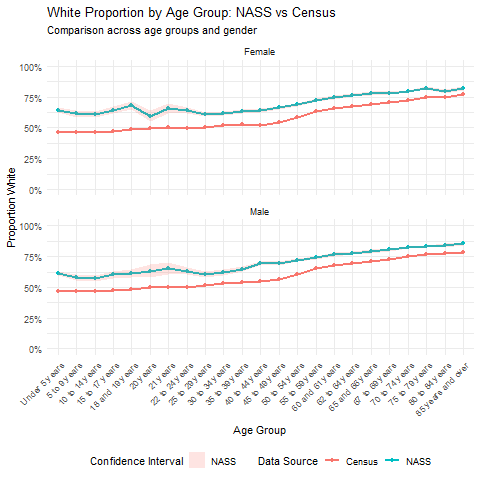

In [55]:
%%R

# ========================================
# Statistical Testing by Age-Gender Groups
# ========================================

cat("=== STATISTICAL TESTING BY AGE-GENDER GROUPS ===\n")

# Perform statistical tests for each age-gender combination
test_results <- merge(nass_proportions, census_proportions, 
                     by.x = c("AGE_GROUP", "GENDER"), 
                     by.y = c("age_group", "gender"),
                     all.x = TRUE)

# Function to perform proportion test safely
safe_prop_test <- function(white_count, total_count, census_prop) {
  if(is.na(white_count) || is.na(total_count) || is.na(census_prop) || 
     total_count == 0 || census_prop == 0 || census_prop == 1) {
    return(list(p.value = NA, significant = FALSE))
  }
  
  tryCatch({
    test_result <- prop.test(white_count, total_count, p = census_prop)
    return(list(p.value = test_result$p.value, 
               significant = test_result$p.value < 0.05))
  }, error = function(e) {
    return(list(p.value = NA, significant = FALSE))
  })
}

# Apply tests
test_results[, c("p_value", "significant") := {
  test_res = safe_prop_test(white, total, proportion_white.y)
  list(test_res$p.value, test_res$significant)
}, by = 1:nrow(test_results)]

cat("Statistical tests completed\n")

# Summary of significant differences
sig_count <- sum(test_results$significant, na.rm = TRUE)
total_tests <- sum(!is.na(test_results$p_value))
cat("Significant differences found:", sig_count, "out of", total_tests, "tests\n")

# Display results table
results_summary <- test_results[, .(
  AGE_GROUP, GENDER,
  NASS_count = total,
  NASS_white_prop = round(proportion_white.x, 3),
  Census_white_prop = round(proportion_white.y, 3),
  p_value = round(p_value, 6),
  significant = significant
)][order(AGE_GROUP, GENDER)]

cat("\nDetailed results by age-gender group:\n")
print(results_summary)

# ========================================
# Visualization
# ========================================

cat("\n=== GENERATING VISUALIZATIONS ===\n")

# Check if ggplot2 is available for plotting
if(require("ggplot2", quietly = TRUE)) {
  
  # Prepare data for plotting
  plot_data_nass <- nass_proportions[, .(
    AGE_GROUP, GENDER, proportion_white, ci_lower, ci_upper, source = "NASS"
  )]
  
  plot_data_census <- census_proportions[, .(
    AGE_GROUP = age_group, GENDER = gender, proportion_white, source = "Census"
  )]
  plot_data_census[, ':='(ci_lower = proportion_white, ci_upper = proportion_white)]
  
  plot_data <- rbind(plot_data_nass, plot_data_census, fill = TRUE)
  
  # Create the plot
  age_gender_plot <- ggplot(plot_data, aes(x = AGE_GROUP, y = proportion_white, 
                                          color = source, group = interaction(source, GENDER))) +
    geom_line(linewidth = 1) +
    geom_point() +
    geom_ribbon(data = plot_data[source == "NASS"], 
                aes(ymin = ci_lower, ymax = ci_upper, fill = source), 
                alpha = 0.2, color = NA) +
    facet_wrap(~GENDER, ncol = 1) +
    labs(title = "White Proportion by Age Group: NASS vs Census",
         subtitle = "Comparison across age groups and gender",
         x = "Age Group",
         y = "Proportion White",
         color = "Data Source",
         fill = "Confidence Interval") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom") +
    scale_y_continuous(limits = c(0, 1), labels = scales::percent)
  
  print(age_gender_plot)
  cat("Visualization generated successfully\n")
  
} else {
  cat("ggplot2 not available - using base R plotting\n")
  
  # Base R fallback plotting
  par(mfrow = c(2, 1), mar = c(8, 4, 4, 2))
  
  # Males plot
  male_nass <- nass_proportions[GENDER == "Male"]
  male_census <- census_proportions[gender == "Male"]
  
  plot(1:nrow(male_nass), male_nass$proportion_white, type = "b", col = "blue",
       xlab = "", ylab = "Proportion White", main = "Males: NASS vs Census",
       ylim = c(0, 1), xaxt = "n")
  lines(1:nrow(male_census), male_census$proportion_white, type = "b", col = "red")
  axis(1, at = 1:nrow(male_nass), labels = male_nass$AGE_GROUP, las = 2, cex.axis = 0.8)
  legend("topright", legend = c("NASS", "Census"), col = c("blue", "red"), lty = 1)
  
  # Females plot
  female_nass <- nass_proportions[GENDER == "Female"]
  female_census <- census_proportions[gender == "Female"]
  
  plot(1:nrow(female_nass), female_nass$proportion_white, type = "b", col = "blue",
       xlab = "Age Group", ylab = "Proportion White", main = "Females: NASS vs Census",
       ylim = c(0, 1), xaxt = "n")
  lines(1:nrow(female_census), female_census$proportion_white, type = "b", col = "red")
  axis(1, at = 1:nrow(female_nass), labels = female_nass$AGE_GROUP, las = 2, cex.axis = 0.8)
  legend("topright", legend = c("NASS", "Census"), col = c("blue", "red"), lty = 1)
  
  par(mfrow = c(1, 1))
  cat("Base R visualization generated\n")
}

cat("\n=== CENSUS AGE-GENDER ANALYSIS COMPLETE ===\n")

---

## 3. Modeling

### Multi-level Modeling

### Machine Learning